In [124]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, max, col, split, explode, lower, regexp_extract, substring
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем сессию Spark
spark = SparkSession.builder \
    .appName("Git Log Analysis") \
    .getOrCreate()


In [105]:
# Загружаем файл
git_log_path = "work/git_log.txt"

# Читаем файл как текстовые данные
data = spark.read.text(git_log_path)

git_df = data.withColumn("columns", split(data["value"], "\\|")) \
             .selectExpr(
                 "columns[0] as hash",
                 "columns[1] as author_name",
                 "columns[2] as author_email",
                 "columns[3] as commit_date",
                 "columns[4] as commit_message"
             )


git_df = git_df.withColumn("commit_date", to_date(git_df.commit_date))


In [106]:
git_df.show()

+--------------------+------------------+--------------------+-----------+--------------------+
|                hash|       author_name|        author_email|commit_date|      commit_message|
+--------------------+------------------+--------------------+-----------+--------------------+
|a7946628449a4c084...|     Oliver Koenig|  okoenig@nvidia.com| 2024-11-30|Merge branch 'ko3...|
|382fa6a8013f9257a...|     Oliver Koenig|  okoenig@nvidia.com| 2024-11-30|ADLR/megatron-lm!...|
|090e2eed9ef574963...|     Oliver Koenig|  okoenig@nvidia.com| 2024-11-30|Merge branch 'dna...|
|0d3d3178e3e923be2...|  Deepak Narayanan|dnarayanan@nvidia...| 2024-11-30|ADLR/megatron-lm!...|
|99f999a46670359ec...|  Deepak Narayanan|dnarayanan@nvidia...| 2024-11-30|Merge branch 'dna...|
|915797035470cf799...|  Deepak Narayanan|dnarayanan@nvidia...| 2024-11-30|ADLR/megatron-lm!...|
|64d816a39c41c1762...|     Oliver Koenig|  okoenig@nvidia.com| 2024-11-30|Merge branch 'par...|
|bb84eb93facd7b27e...|Selvaraj Anandaraj

In [107]:
git_df.groupBy("author_name").count().orderBy("count", ascending=False).show()

+------------------+-----+
|       author_name|count|
+------------------+-----+
|      Jared Casper|  949|
|     Oliver Koenig|  503|
|   Lawrence McAfee|  359|
|Shanmugam Ramasamy|  248|
|  Deepak Narayanan|  232|
|        shanmugamr|  205|
|      Mikołaj Błaż|  204|
|       Eric Harper|  186|
|         Neel Kant|  159|
| Vijay Korthikanti|  148|
|   Mostofa Patwary|  137|
|  Mohammad Shoeybi|  111|
|        Jon Barker|   93|
|      Maanu Grover|   89|
|          rprenger|   89|
|          mohammad|   86|
|Selvaraj Anandaraj|   81|
|          Mohammad|   80|
|            zihanl|   77|
|          mshoeybi|   62|
+------------------+-----+
only showing top 20 rows



In [108]:
top_author = git_df.groupBy("author_name").count() \
                   .orderBy(col("count").desc()) \
                   .limit(5)

# Показать результат
top_author.show(truncate=False)

+------------------+-----+
|author_name       |count|
+------------------+-----+
|Jared Casper      |949  |
|Oliver Koenig     |503  |
|Lawrence McAfee   |359  |
|Shanmugam Ramasamy|248  |
|Deepak Narayanan  |232  |
+------------------+-----+



In [109]:
top_author = git_df.groupBy("author_name").count() \
                   .orderBy(col("count").asc()) \
                   .limit(5)

# Показать результат
top_author.show(truncate=False)

+--------------+-----+
|author_name   |count|
+--------------+-----+
|s6690609      |1    |
|ZeldaHuang    |1    |
|Michal Futrega|1    |
|Meg Miranda   |1    |
|Taebum Kim    |1    |
+--------------+-----+



In [110]:
git_df_with_domain = git_df.withColumn(
    "email_domain", 
    regexp_extract(col("author_email"), r"@([^.]+)", 1)  # Извлекаем домен до первой точки
)

In [111]:
top_author = git_df_with_domain.groupBy("email_domain").count() \
                   .orderBy(col("count").desc()) \
                   .limit(20)

# Показать результат
top_author.show(truncate=False)

+--------------------------+-----+
|email_domain              |count|
+--------------------------+-----+
|nvidia                    |4932 |
|gmail                     |218  |
|shanmugamr-mlt            |68   |
|login-eos01               |66   |
|selene-login-01           |20   |
|computelab-frontend-4-ub22|11   |
|umontreal                 |7    |
|NULL                      |6    |
|login-eos02               |6    |
|posteo                    |5    |
|naver                     |5    |
|users                     |5    |
|qq                        |4    |
|draco-oci-login-01        |4    |
|luna-0481                 |4    |
|berkeley                  |4    |
|computelab-frontend-3     |3    |
|computelab-frontend-1     |3    |
|dgx0092                   |2    |
|draco-aws2-login-01       |2    |
+--------------------------+-----+



In [112]:
top_author = git_df_with_domain.groupBy("email_domain").count() \
                   .orderBy(col("count").asc()) \
                   .limit(20)

# Показать результат
top_author.show(truncate=False)

+-----------------+-----+
|email_domain     |count|
+-----------------+-----+
|xiaohongshu      |1    |
|luna-0194        |1    |
|draco-oci-dc-01  |1    |
|batch-p4d-cr3-027|1    |
|outlook          |1    |
|dgx0042          |1    |
|tu-dresden       |1    |
|sk               |1    |
|stason           |1    |
|batch-p4d-cr3-029|1    |
|subl             |1    |
|draco-oci-dc-3   |1    |
|weekly           |1    |
|draco-oci-login  |1    |
|huawei           |1    |
|malayn-mlt       |1    |
|luna-0198        |1    |
|protonmail       |1    |
|luna-0006        |1    |
|fb               |1    |
+-----------------+-----+



/tmp/ipykernel_1086/1681903146.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_domains_pd, x="email_domain", y="count", palette="coolwarm")


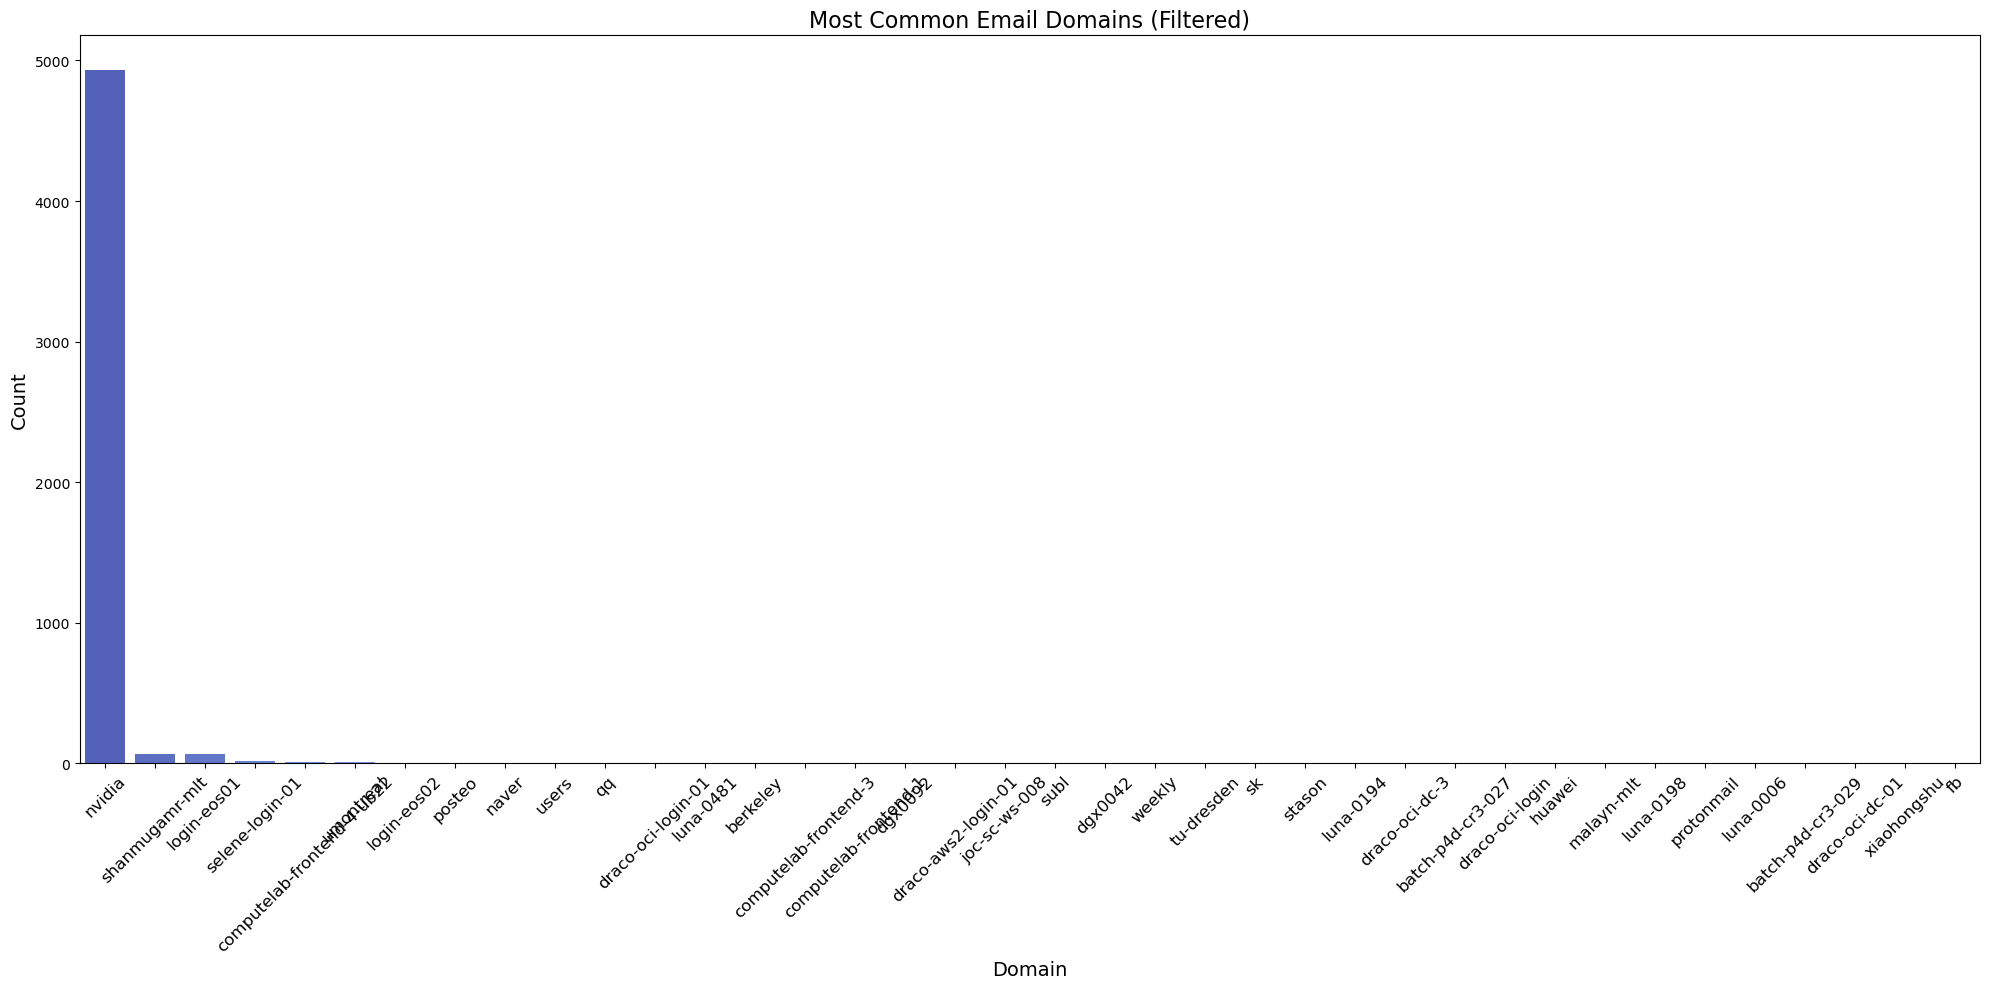

In [130]:
exclude_domains = ["gmail", "outlook", "yahoo", "NULL"]

filtered_domains_df = git_df_with_domain.filter(~col("email_domain").isin(exclude_domains))

domain_count_df = filtered_domains_df.groupBy("email_domain").count().orderBy(col("count").desc())

top_domains_pd = domain_count_df.toPandas()

plt.figure(figsize=(20, 10))
sns.barplot(data=top_domains_pd, x="email_domain", y="count", palette="coolwarm")
plt.title("Most Common Email Domains (Filtered)", fontsize=16)
plt.xlabel("Domain", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1086/2185437633.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words_pd, x="word", y="count", palette="viridis")


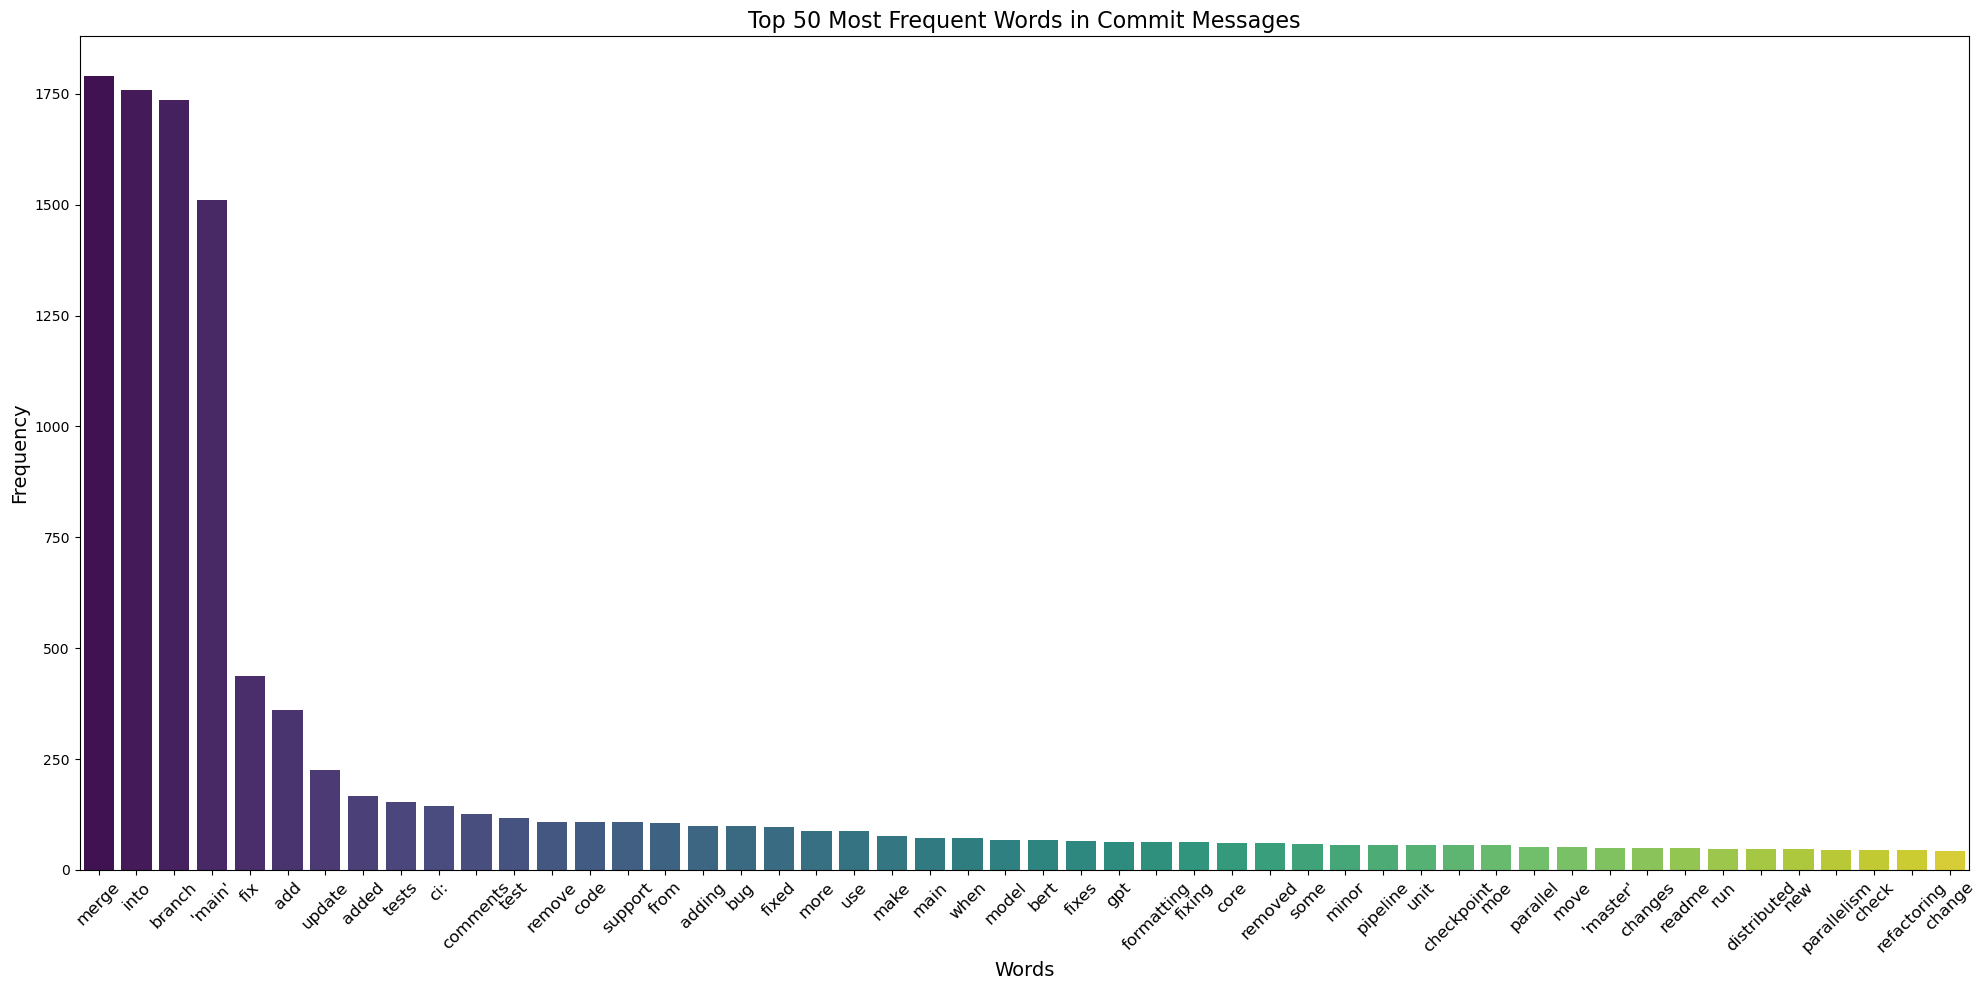

In [129]:
stop_words = ["the", "and", "is", "to", "in", "of", "a", "for", "on", "with", "-", "for", "te"]

words_df = git_df.select(explode(split(lower(col("commit_message")), r"\s+")).alias("word"))
words_df = words_df.filter((col("word") != "") & (~col("word").isin(stop_words)))

# Убрать пустые строки и подсчитать частоту каждого слова
word_count_df = words_df.filter(col("word") != "") \
                        .groupBy("word").count() \
                        .orderBy(col("count").desc())
                        

# Выбрать топ-20 самых частых слов и преобразовать в Pandas DataFrame
top_words_pd = word_count_df.limit(50).toPandas()

# Построить график с помощью seaborn
plt.figure(figsize=(20, 10))
sns.barplot(data=top_words_pd, x="word", y="count", palette="viridis")

# Настроить внешний вид графика
plt.title("Top 50 Most Frequent Words in Commit Messages", fontsize=16)
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# Показать график
plt.show()

In [131]:
years_df = git_df.select(substring(col("commit_date"), 1, 4).alias("year"))
years_df_count = years_df.groupBy("year").count().orderBy(col("count").desc())
years_df_count.show()

+----+-----+
|year|count|
+----+-----+
|2024| 1999|
|2023| 1689|
|2021|  658|
|2020|  568|
|2022|  416|
|2019|   61|
|NULL|    6|
+----+-----+

